In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import time 
import random
import json
import torch
from torch.nn.utils.rnn import pack_sequence
from torch.utils.data import DataLoader,Dataset

In [5]:
#for colab
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/My Drive/Pylon/test_examples/full_labeled_data

### Process Raw Data to Generate Primitive Activitiy Dataset
The data we use here is from the Third Nurse Care Activity Recognition Challenge. It contains 3-dimensional accelerometer data from 12 subjects performing 27 different activities. We have filtered out noisy data and stored them in 'data_full.json', but further preprocessing is necessary since each activity data has arbitrary length. We are going to segment each data with the same lenghth, and choose the activity classes with balanced training data size to be the primitive activities.

In [6]:
'''Read file and convert string to Python dict'''

with open('./complex_event/data_full.json','r') as f:
  load_dict = json.load(f)
  # print(load_dict)


In [7]:
'''Segment the raw data into same time length'''

SEGMENT_SIZE = 20
SLIDING_SIZE = SEGMENT_SIZE

'''Choose primitive activitiy class indexed by target_label'''

target_label = [4, 2, 12, 9]
label_map = {4:0, 2:1, 12:2, 9:3}

n_class = len(target_label)
n_data_per_class = 2000

In [8]:
'''Generate primitive activity data'''

from collections import Counter

x_prim_data = []
y_prim_data = []
time_period = set()
activity_len = {}
for item in load_dict:
  x, y, start, finish = item['acc'], item['old_label'], item['start'], item['finish']
  counter = dict(Counter(y_prim_data))
  if y in target_label and (start, finish) not in time_period and len(x) >= SEGMENT_SIZE:
    # Check duplicates
    time_period.add((start, finish))
    # Divide y into segements of length SEGMENT_SIZE
    # TODO: Here just discard segments with length smaller than SEGMENT_SIZE, we can use imputation later to keep them
    if SLIDING_SIZE == 0:
      raise Exception("SLIDING_SIZE cannot be zero")
    num = int((len(x) - SEGMENT_SIZE)/SLIDING_SIZE) + 1
    for i in range(num):
      x_i = x[i * SLIDING_SIZE:i * SLIDING_SIZE + SEGMENT_SIZE]
      # y_i = y
      y_i = label_map[y]
      x_prim_data.append(x_i)
      y_prim_data.append(y_i)
      
      # count the number of data with different length for each activity
      length = len(x_i)
      if y not in activity_len:
        activity_len[y] = [length]
      else:
        activity_len[y].append(length)
      


print(len(x_prim_data))
result = dict(Counter(y_prim_data))
print(result)


# count the number of data with different length for each activity
for key, val in activity_len.items():
  n = Counter(val)
  print("Activity",key,":")
  print("The range of data length is (", min(val), ",", max(val), ")")
  print("The distribution of data length is", n)

temp = list(zip(x_prim_data, y_prim_data))
random.shuffle(temp)
res1, res2 = zip(*temp)
# res1 and res2 come out as tuples, and so must be converted to lists.
x_prim_data, y_prim_data = list(res1), list(res2)

x_prim_data = np.array(x_prim_data).transpose((0,2,1))
x_prim_data = x_prim_data.astype(np.float32)
y_prim_data = np.array(y_prim_data)

# balance data set of different activities
x_prim_data_temp = np.zeros([n_data_per_class, x_prim_data.shape[1], x_prim_data.shape[2]])
y_prim_data_temp = np.zeros([n_data_per_class, 1])
for i in range(n_class):
  idx = np.where(y_prim_data==i)[0]
  idx = np.random.choice(idx, n_data_per_class, replace=False)
  if i == 0:
    x_prim_data_temp = x_prim_data[idx] 
    y_prim_data_temp = y_prim_data[idx] 
  else:
    x_prim_data_temp = np.concatenate([x_prim_data_temp,x_prim_data[idx]],axis=0)
    y_prim_data_temp = np.concatenate([y_prim_data_temp,y_prim_data[idx]],axis=0)

x_prim_data = x_prim_data_temp
y_prim_data = y_prim_data_temp

# shuffle again
temp = list(zip(x_prim_data, y_prim_data))
random.shuffle(temp)
res1, res2 = zip(*temp)
# res1 and res2 come out as tuples, and so must be converted to lists.
x_prim_data, y_prim_data = list(res1), list(res2)

x_prim_data = np.array(x_prim_data)
x_prim_data.astype(np.float32)
y_prim_data = np.array(y_prim_data)

# split some data to test set
x_prim_test = x_prim_data[-int(n_data_per_class/4*n_class):]
x_prim_train = x_prim_data[:-int(n_data_per_class/4*n_class)]
y_prim_test = y_prim_data[-int(n_data_per_class/4*n_class):]
y_prim_train = y_prim_data[:-int(n_data_per_class/4*n_class)]

print(dict(Counter(y_prim_test)))

print(x_prim_train.shape)
print(y_prim_train.shape)
print(x_prim_test.shape)
print(y_prim_test.shape)

x_prim_train = torch.from_numpy(x_prim_train)
y_prim_train = torch.from_numpy(y_prim_train)
x_prim_test = torch.from_numpy(x_prim_test)
y_prim_test = torch.from_numpy(y_prim_test)

# print(x_prim_train.shape)
# print(y_prim_train.shape)
# print(x_prim_test.shape)
# print(y_prim_test.shape)


43542
{0: 17684, 1: 18268, 3: 2948, 2: 4642}
Activity 4 :
The range of data length is ( 20 , 20 )
The distribution of data length is Counter({20: 17684})
Activity 2 :
The range of data length is ( 20 , 20 )
The distribution of data length is Counter({20: 18268})
Activity 9 :
The range of data length is ( 20 , 20 )
The distribution of data length is Counter({20: 2948})
Activity 12 :
The range of data length is ( 20 , 20 )
The distribution of data length is Counter({20: 4642})
{3: 509, 2: 496, 0: 503, 1: 492}
(6000, 3, 20)
(6000,)
(2000, 3, 20)
(2000,)


In [9]:
print(np.array(x_prim_train).shape)
print(np.array(x_prim_test).shape)

(6000, 3, 20)
(2000, 3, 20)


### Neural Modules to Calssify Primitive Activity

In [10]:
'''Define Neural Architecture'''

from torch.nn.modules.activation import Softmax
from torch.nn.modules import dropout
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class CRNN(nn.Module):
    def __init__(self, n_class, drop_out=0.5):
      super().__init__()
      self.n_class = n_class
      self.conv = nn.Sequential(
          nn.Conv1d(in_channels=3, out_channels=8, kernel_size=3, padding='same'),
          nn.LeakyReLU(),
          nn.MaxPool1d(kernel_size=3, stride=3),
          nn.BatchNorm1d(num_features=8),
          nn.Dropout(drop_out),

          # nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, padding='same'),
          # nn.LeakyReLU(),
          # nn.MaxPool1d(kernel_size=3, stride=3),
          # nn.BatchNorm1d(num_features=16),
          # nn.Dropout(drop_out)
      )

      self.lstm = nn.LSTM(input_size=6, hidden_size=8, bidirectional=True, batch_first=True)
      self.fc = nn.Sequential(
          nn.LeakyReLU(),
          nn.Dropout(drop_out),
          nn.Flatten(),
          nn.Linear(in_features=128, out_features=self.n_class),
          nn.Softmax(dim=1)
      )
        

    def forward(self, x):
      x = self.conv(x)
      # print(x.shape)
      x, _ = self.lstm(x)
      # print(x.shape)
      x = self.fc(x)
      # print(x.shape)
      return x



In [11]:
'''Baseline training on neural module directly (not used in Pylon implementation)'''

def train(model, x_train, y_train, epoch, batch_size):
  batch_num = int(np.ceil(x_train.shape[0] / batch_size))
  for k in range(epoch):  # loop over the dataset multiple times
    running_loss = 0.0
    running_acc = 0.0
    for i in range(batch_num):
        # get the inputs; data is a list of [inputs, labels]
        if i == batch_num - 1:
          inputs, labels = x_train[i * batch_size:], y_train[i * batch_size:]
        else:
          inputs, labels = x_train[i * batch_size:(i + 1) * batch_size], y_train[i * batch_size:(i + 1) * batch_size]
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        running_acc += (predicted == labels).sum().item() / batch_size
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[{k + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f} acc: {running_acc / 100:.3f}')
            running_loss = 0.0
            running_acc = 0.0

  print('Finished Training')


In [12]:
'''Evaluation function used for primitive activity classification'''

def evaluate(model, x_test, y_test):
  correct = 0
  total = y_test.shape[0]
  with torch.no_grad():
    inputs, labels = x_test, y_test
    outputs = model(inputs)
    _, predict = torch.max(outputs.data, 1)
    correct = (predict == labels).sum().item() / total

  print('Accuracy of the network on the test data: %d %%' % (
    100 * correct))
  
  class_correct = list(0. for i in range(model.n_class))
  class_total = list(0. for i in range(model.n_class))
  with torch.no_grad():
    inputs, labels = x_test, y_test
    outputs = model(inputs)
    _, predict = torch.max(outputs.data, 1)
    c = (predict == labels).squeeze()
    for i in range(labels.shape[0]):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

  print(class_total)
  for i in range(model.n_class):
    print('Accuracy of activity %2s : %2d %%' % (
    i, 100 * class_correct[i] / class_total[i]))
  return [predict, correct]


### Define FSM for complex events

In [13]:
'''Build FSM class'''

class FSM:
    def __init__(self, label):
        self.label = label
        self.init_state = 'init'
        self.final_state = 'final'
        
    def state_transition(curr_state, curr_input):
        raise NotImplementedError

    def traverse(self, curr_state, input_sequence):
        if curr_state == self.final_state:
            return True
        if len(input_sequence) == 0:
            return False
        curr_input = input_sequence[0]
        next_state = self.state_transition(curr_state, curr_input)
        return self.traverse(next_state, input_sequence[1:])

    def check(self, input_sequence):
        return self.traverse(self.init_state, input_sequence)


class Event0(FSM):
    def __init__(self):
        super().__init__(label=0)

    def state_transition(self, curr_state, curr_input):
        if curr_state == 'init':
            if curr_input == 1:
                next_state = 's1'
            else:
                next_state = 'init'
        elif curr_state == 's1':
            if curr_input == 3:
                next_state = 'final'
            else:
                next_state = 's1'
        elif curr_state == 'final':
            if curr_input == 3:
                next_state == 'final'
            else:
                next_state == 'init'
        else:
            raise Exception(f'State "{curr_state}" is not defined.')
        # print(next_state)
        return next_state

class Event1(FSM):
    def __init__(self):
        super().__init__(label=1)

    def state_transition(self, curr_state, curr_input):
        if curr_state == 'init':
            if curr_input == 0:
                next_state = 's1'
            else:
                next_state = 'init'
        elif curr_state == 's1':
            if curr_input == 2:
                next_state = 'final'
            else:
                next_state = 's1'
        elif curr_state == 'final':
            if curr_input == 2:
                next_state == 'final'
            else:
                next_state == 'init'
        else:
            raise Exception(f'State "{curr_state}" is not defined.')
        # print(next_state)
        return next_state

# Some tests
e0 = Event0()
e1 = Event1()
sequence = [1,2,1,3,0]
result1 = e0.check(sequence)
result2 = e1.check(sequence)

print(result1, result2)

sequence = [2,2,0,2,1]
result1 = e0.check(sequence)
result2 = e1.check(sequence)
print(result1, result2)

True False
False True


### Generate Complex Event Dataset

In [31]:
''' Generate complex event training/test set using prmitive activities '''

n_event_data = 10000
n_event_class = 2
event_length = 3

''' 
event_dict[key]: complex event class ID.
event_dict[item]: complex event pattern of the corresponding complex event class.

In this simple example, event 0 means "primitive activity 1 happens before 3", event 1 means "primitive activity 0 happens before 2"
'''
event_0 = Event0()
event_1 = Event1()
event_fsm = [event_0, event_1]

idx_list = []
for label in range(n_class):
    idx = list(np.where(y_prim_data == label)[0])
    idx_list.append(idx)

x_event = np.empty((0, x_prim_data.shape[1], x_prim_data.shape[2] * event_length))
y_event = np.empty((0))

while len(x_event) < n_event_data:
    # generate a random combination of primitive activities
    activity_comb = np.random.choice(n_class, event_length)

    for fsm in event_fsm:
        if fsm.check(activity_comb) == True:
            # label this data
            event_label = fsm.label
            y_event = np.append(y_event, event_label)
            x_event_sub = np.empty((1, x_prim_data.shape[1], 0))
            for activity_class in activity_comb:
                x_event_sub = np.append(x_event_sub, x_prim_data[np.random.choice(idx_list[activity_class], 1)], axis=-1)

            x_event = np.append(x_event, x_event_sub, axis=0)
            # currently only consider single label case
            break
    
# shuffle the list
temp = list(zip(x_event, y_event))
random.shuffle(temp)
res1, res2 = zip(*temp)
# res1 and res2 come out as tuples, and so must be converted to lists.
x_event, y_event = np.array(res1), np.array(res2)

# Construct trainig set and test set
x_event = x_event.astype(np.float32)
y_event = y_event.astype(np.int32)

# x_event, y_event = utils.shuffle(x_event, y_event)

x_event_train = x_event[:-int(n_event_data/5)]
x_event_test = x_event[-int(n_event_data/5):]
y_event_train = y_event[:-int(n_event_data/5)]
y_event_test = y_event[-int(n_event_data/5):]

x_event_train = torch.from_numpy(x_event_train)
y_event_train = torch.from_numpy(y_event_train)
x_event_test = torch.from_numpy(x_event_test)
y_event_test = torch.from_numpy(y_event_test)

print(x_event_train.shape)
print(y_event_train.shape)
print(x_event_test.shape)
print(y_event_test.shape)

print(y_event_train)

torch.Size([8000, 3, 60])
torch.Size([8000])
torch.Size([2000, 3, 60])
torch.Size([2000])
tensor([0, 0, 0,  ..., 0, 0, 1], dtype=torch.int32)


In [32]:
print(np.array(x_event_train).shape)
print(np.array(x_event_test).shape)

(8000, 3, 60)
(2000, 3, 60)


In [57]:
'''Process input sequence by a fixed window size'''

def predict_sequence(model, x_event, segment_size):
    '''
    model: the primitive activity classifer
    x_event: the complex event data of shape (batch_size, num_channel, sequence_length)
    segment_size: the length of the input required by primitive activity classifier
    '''
    segments_num = int(x_event.shape[-1] / segment_size)
    logits_sequence = []

    for i in range(segments_num):
        x_event_temp = x_event[:,:,i * segment_size:(i + 1) * segment_size]
        output = model(x_event_temp)
        logits_sequence.append(output)
    
    return logits_sequence

### Define FSM constraints

In [34]:
'''Define constraint function and Pylon constraint loss'''

import sys
sys.path.append("../")

from pylon.constraint import constraint
from pylon.brute_force_solver import SatisfactionBruteForceSolver
# from pylon.brute_force_solver import *

def complex_event(*logits_sequence, **kwargs):
    '''
    logits_sequence: a sequence of logits tensors returned by the primitive classifier
    kwargs['event_label']: ground truth complex event label
    kwargs['event_fsm']: a list of finite state machines for corresponding complex event class
    '''

    for fsm in kwargs['event_fsm']:
        if fsm.check(logits_sequence) == True: # (torch,torch,torch) == (int,int,int) in pylon constraints
            return fsm.label == kwargs['event_label']
    return False

complex_event_cons = constraint(complex_event, SatisfactionBruteForceSolver())

## Training and Evaluation

In [60]:
model = CRNN(n_class)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [61]:
predict, acc = evaluate(model, x_prim_test, y_prim_test)

Accuracy of the network on the test data: 26 %
[503.0, 492.0, 496.0, 509.0]
Accuracy of activity  0 : 11 %
Accuracy of activity  1 : 33 %
Accuracy of activity  2 : 22 %
Accuracy of activity  3 : 31 %


In [62]:
from tqdm import tqdm
from examples.plothelper import PlotHelper

NUM_EPOCHS = 1

plot_loss = PlotHelper()

for epoch in range(NUM_EPOCHS):
      
    # train
    for i in tqdm(range(len(x_event_train))):
        model.train()
        optimizer.zero_grad()
        # print(len(x_event_train))
        logits_sequence = predict_sequence(model, x_event_train[i].unsqueeze(0), SEGMENT_SIZE)
        
        closs = complex_event_cons(*logits_sequence, event_label=y_event_train[i], event_fsm=event_fsm)

        closs.backward()
        optimizer.step()
        
        # with torch.no_grad():
        #     dampner = closs
        dampner = closs.detach()
        plot_loss.add(cons_loss = dampner)

        if i % 1000 == 0 and i != 0:
            evaluate(model, x_prim_test, y_prim_test)
        
    evaluate(model, x_prim_test, y_prim_test)

  0%|          | 0/8000 [00:00<?, ?it/s]/Users/hanliying/Documents/UCLA/Research/master-thesis-project/CEP-pylon/CE-examples/../pylon/brute_force_solver.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else torch.tensor(data=self.cond(*sample,**kwargs), dtype=torch.bool) for sample in samples ])
 13%|█▎        | 1003/8000 [00:24<03:15, 35.82it/s]

Accuracy of the network on the test data: 35 %
[503.0, 492.0, 496.0, 509.0]
Accuracy of activity  0 :  3 %
Accuracy of activity  1 : 81 %
Accuracy of activity  2 : 10 %
Accuracy of activity  3 : 44 %


 25%|██▌       | 2007/8000 [00:48<02:47, 35.83it/s]

Accuracy of the network on the test data: 43 %
[503.0, 492.0, 496.0, 509.0]
Accuracy of activity  0 : 21 %
Accuracy of activity  1 : 77 %
Accuracy of activity  2 : 15 %
Accuracy of activity  3 : 60 %


 38%|███▊      | 3003/8000 [01:11<02:20, 35.69it/s]

Accuracy of the network on the test data: 36 %
[503.0, 492.0, 496.0, 509.0]
Accuracy of activity  0 :  0 %
Accuracy of activity  1 : 73 %
Accuracy of activity  2 :  0 %
Accuracy of activity  3 : 70 %


 50%|█████     | 4008/8000 [01:34<01:41, 39.37it/s]

Accuracy of the network on the test data: 37 %
[503.0, 492.0, 496.0, 509.0]
Accuracy of activity  0 :  7 %
Accuracy of activity  1 : 77 %
Accuracy of activity  2 :  0 %
Accuracy of activity  3 : 70 %


 63%|██████▎   | 5008/8000 [01:56<01:16, 38.96it/s]

Accuracy of the network on the test data: 45 %
[503.0, 492.0, 496.0, 509.0]
Accuracy of activity  0 : 31 %
Accuracy of activity  1 : 75 %
Accuracy of activity  2 :  0 %
Accuracy of activity  3 : 70 %


 75%|███████▌  | 6008/8000 [02:19<00:49, 40.37it/s]

Accuracy of the network on the test data: 45 %
[503.0, 492.0, 496.0, 509.0]
Accuracy of activity  0 : 26 %
Accuracy of activity  1 : 76 %
Accuracy of activity  2 :  7 %
Accuracy of activity  3 : 73 %


 88%|████████▊ | 7003/8000 [02:43<00:28, 35.11it/s]

Accuracy of the network on the test data: 43 %
[503.0, 492.0, 496.0, 509.0]
Accuracy of activity  0 : 24 %
Accuracy of activity  1 : 78 %
Accuracy of activity  2 :  7 %
Accuracy of activity  3 : 67 %


100%|██████████| 8000/8000 [03:06<00:00, 42.91it/s]


Accuracy of the network on the test data: 45 %
[503.0, 492.0, 496.0, 509.0]
Accuracy of activity  0 : 20 %
Accuracy of activity  1 : 74 %
Accuracy of activity  2 :  9 %
Accuracy of activity  3 : 73 %


/Users/hanliying/Documents/UCLA/Research/master-thesis-project/CEP-pylon/CE-examples/../examples/plothelper.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


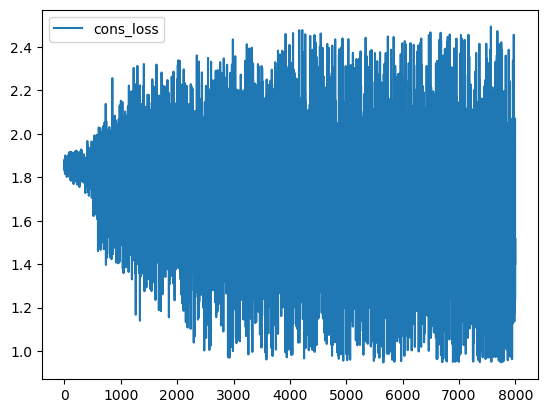

In [63]:
plot_loss.show()

In [22]:
dampner.requires_grad

False

In [23]:
# some tests
x = torch.tensor([1.], requires_grad=True)
with torch.no_grad():
    y = x * 2

@torch.no_grad()
def doubler(x):
    return x * 2
z = doubler(x)

x.requires_grad # True
y.requires_grad # False
z.requires_grad # False

False